# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_068  P12111           17.405
Sample_083  Q8IZS8           15.685
Sample_020  H9KV31;O15394    19.241
Sample_081  P01601           15.847
Sample_099  Q9BUJ0           15.491
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups      
Sample_048  A0A075B6Q5             16.710
Sample_042  Q9NS00;Q9NS00-2        13.714
Sample_123  H3BRQ4;K4DIB9;P50238   12.140
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.362
            A0A075B6Q5                 13.193
            A0A075B6R2                 14.166
            A0A075B6S5                 11.854
            A0A087WSY4                 12.536
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.660
            Q9UI40;Q9UI40-2            14.018
            Q9UIW2                     12.458
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.806
            Q9UP79                     12.680
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.068,15.050,16.842,19.863,16.228,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.181,19.067,...,15.528,15.576,14.191,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.866,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.863,17.705,17.039,15.680,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.470,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.565,15.345,17.084,18.708,14.249,19.433,12.504,11.199
Sample_207,15.739,16.877,15.469,16.898,14.977,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.362,...,16.012,15.178,13.081,15.050,16.842,19.863,12.268,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.222,19.067,16.188,...,15.528,15.576,11.876,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.630,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,14.453,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.007,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.024,15.345,17.084,18.708,14.249,19.433,12.173,12.820
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 368.70it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.95it/s]

100%|██████████| 2/2 [00:00<00:00,  3.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.18it/s]

100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.66it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.54it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.00it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.66it/s]

100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

100%|██████████| 5/5 [00:01<00:00,  3.60it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.63it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.89it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.20it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.05it/s]

100%|██████████| 6/6 [00:01<00:00,  2.92it/s]

100%|██████████| 6/6 [00:01<00:00,  3.23it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.28it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.92it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.34it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.08it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.00it/s]

100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.05it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.21it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.12it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.97it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.77it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.65it/s]

100%|██████████| 8/8 [00:02<00:00,  2.84it/s]

100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.39it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.35it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.02it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.78it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.67it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.65it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.63it/s]

100%|██████████| 9/9 [00:03<00:00,  2.83it/s]

100%|██████████| 9/9 [00:03<00:00,  2.88it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.51it/s]

 30%|███       | 3/10 [00:00<00:02,  3.50it/s]

 40%|████      | 4/10 [00:01<00:01,  3.12it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.96it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.73it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.63it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.47it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.65it/s]

100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

100%|██████████| 10/10 [00:03<00:00,  2.84it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.20it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.43it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.77it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.63it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.50it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.44it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.47it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.52it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.73it/s]

100%|██████████| 11/11 [00:03<00:00,  2.88it/s]

100%|██████████| 11/11 [00:03<00:00,  2.78it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.62it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.50it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.94it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.65it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.59it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.58it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.58it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.77it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.78it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.96it/s]

100%|██████████| 12/12 [00:04<00:00,  3.04it/s]

100%|██████████| 12/12 [00:04<00:00,  2.90it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.57it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.35it/s]

 31%|███       | 4/13 [00:01<00:03,  2.84it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.76it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.64it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.58it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.56it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.50it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.68it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.69it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.84it/s]

100%|██████████| 13/13 [00:04<00:00,  2.97it/s]

100%|██████████| 13/13 [00:04<00:00,  2.83it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.26it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.52it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.94it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.78it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.87it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.69it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.63it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.55it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.37it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.51it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.73it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.87it/s]

100%|██████████| 14/14 [00:04<00:00,  2.99it/s]

100%|██████████| 14/14 [00:04<00:00,  2.84it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.60it/s]

 20%|██        | 3/15 [00:00<00:03,  3.46it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.33it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.11it/s]

 40%|████      | 6/15 [00:01<00:03,  2.87it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.82it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.78it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.68it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.58it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.54it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.57it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.76it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.90it/s]

100%|██████████| 15/15 [00:05<00:00,  3.06it/s]

100%|██████████| 15/15 [00:05<00:00,  2.91it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.069 0.025          0.796 0.321       0.120   
2             0.004 0.003      0.067 0.026          0.771 0.090       0.703   
3             0.005 0.004      0.059 0.022          0.764 0.091       0.694   
4             0.004 0.002      0.055 0.018          0.779 0.096       0.693   
5             0.004 0.002      0.055 0.023          0.756 0.106       0.703   
6             0.005 0.004      0.058 0.022          0.792 0.093       0.797   
7             0.005 0.003      0.051 0.012          0.785 0.096       0.791   
8             0.004 0.002      0.053 0.020          0.855 0.077       0.853   
9             0.005 0.004      0.056 0.024          0.854 0.077       0.859   
10            0.004 0.000      0.056 0.027          0.852 0.074       0.857   
11            0.005 0.005      0.067 0.035          0.851 0.076       0.851   
12            0.006 0.005      0.066 0.030          0.850 0.077       0.848   
13            0.006 0.005      0.068 0.032          0.843 0.071       0.841   
14            0.006 0.004      0.064 0.032          0.836 0.077       0.828   
15            0.004 0.002      0.060 0.031          0.831 0.077       0.824   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.201 0.126                  0.553 0.041        0.854   
2          0.102   0.730 0.073                  0.773 0.057        0.854   
3          0.108   0.721 0.076                  0.767 0.059        0.849   
4          0.102   0.727 0.070                  0.771 0.054        0.849   
5          0.099   0.723 0.080                  0.766 0.065        0.857   
6          0.098   0.790 0.071                  0.820 0.059        0.908   
7          0.109   0.782 0.079                  0.814 0.065        0.905   
8          0.096   0.850 0.067                  0.872 0.058        0.926   
9          0.090   0.854 0.068                  0.875 0.059        0.927   
10         0.090   0.851 0.066                  0.873 0.056        0.926   
11         0.088   0.848 0.065                  0.870 0.056        0.924   
12         0.090   0.846 0.067                  0.868 0.057        0.923   
13         0.094   0.839 0.066                  0.863 0.055        0.922   
14         0.093   0.829 0.068                  0.854 0.057        0.920   
15         0.095   0.824 0.068                  0.850 0.058        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.826 0.089        210.000 0.000  
2          0.057                  0.811 0.083        210.000 0.000  
3          0.057                  0.805 0.082        210.000 0.000  
4          0.057                  0.811 0.083        210.000 0.000  
5          0.054                  0.823 0.073        210.000 0.000  
6          0.044                  0.891 0.051        210.000 0.000  
7          0.045                  0.889 0.051        210.000 0.000  
8          0.041                  0.911 0.049        210.000 0.000  
9          0.042                  0.914 0.049        210.000 0.000  
10         0.042                  0.913 0.049        210.000 0.000  
11         0.044                  0.910 0.051        210.000 0.000  
12         0.044                  0.908 0.052        210.000 0.000  
13         0.044                  0.910 0.050        210.000 0.000  
14         0.045                  0.908 0.050        210.000 0.000  
15         0.045                  0.906 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 466.19it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.56it/s]

100%|██████████| 3/3 [00:00<00:00,  4.17it/s]

100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.01it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.22it/s]

100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.23it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.85it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.74it/s]

100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.81it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.00it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.66it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.54it/s]

100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.38it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.65it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.39it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.44it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.38it/s]

100%|██████████| 7/7 [00:02<00:00,  2.38it/s]

100%|██████████| 7/7 [00:02<00:00,  2.48it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:02,  2.99it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.51it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.33it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.33it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.28it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.37it/s]

100%|██████████| 8/8 [00:03<00:00,  2.38it/s]

100%|██████████| 8/8 [00:03<00:00,  2.40it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.70it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.79it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.52it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.00it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.70it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.51it/s]

 89%|████████▉ | 8/9 [00:04<00:00,  1.65it/s]

100%|██████████| 9/9 [00:04<00:00,  1.78it/s]

100%|██████████| 9/9 [00:04<00:00,  1.91it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.68it/s]

 30%|███       | 3/10 [00:01<00:02,  2.53it/s]

 40%|████      | 4/10 [00:01<00:02,  2.26it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.07it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.13it/s]

 70%|███████   | 7/10 [00:03<00:01,  2.23it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.28it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.22it/s]

100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.02it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.04it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.59it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.41it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.33it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.26it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.92it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.71it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.68it/s]

100%|██████████| 11/11 [00:05<00:00,  1.70it/s]

100%|██████████| 11/11 [00:05<00:00,  2.03it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:03,  2.92it/s]

 25%|██▌       | 3/12 [00:01<00:04,  1.91it/s]

 33%|███▎      | 4/12 [00:02<00:04,  1.74it/s]

 42%|████▏     | 5/12 [00:02<00:04,  1.75it/s]

 50%|█████     | 6/12 [00:03<00:03,  1.79it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.77it/s]

 67%|██████▋   | 8/12 [00:04<00:02,  1.92it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.92it/s]

 83%|████████▎ | 10/12 [00:05<00:01,  1.97it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  2.17it/s]

100%|██████████| 12/12 [00:05<00:00,  2.34it/s]

100%|██████████| 12/12 [00:05<00:00,  2.02it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.76it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.68it/s]

 31%|███       | 4/13 [00:01<00:03,  2.33it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.21it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.19it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.15it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.17it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.09it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.12it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.17it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.37it/s]

100%|██████████| 13/13 [00:05<00:00,  2.35it/s]

100%|██████████| 13/13 [00:05<00:00,  2.30it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.08it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.82it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.49it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.40it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.25it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.21it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.95it/s]

 64%|██████▍   | 9/14 [00:04<00:03,  1.63it/s]

 71%|███████▏  | 10/14 [00:05<00:02,  1.56it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.72it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.89it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  2.00it/s]

100%|██████████| 14/14 [00:06<00:00,  2.13it/s]

100%|██████████| 14/14 [00:06<00:00,  2.07it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.12it/s]

 20%|██        | 3/15 [00:01<00:04,  2.44it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.06it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.70it/s]

 40%|████      | 6/15 [00:03<00:05,  1.78it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.94it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.98it/s]

 60%|██████    | 9/15 [00:04<00:03,  2.00it/s]

 67%|██████▋   | 10/15 [00:05<00:02,  1.85it/s]

 73%|███████▎  | 11/15 [00:05<00:01,  2.03it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.12it/s]

 87%|████████▋ | 13/15 [00:06<00:00,  2.26it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.30it/s]

100%|██████████| 15/15 [00:07<00:00,  2.31it/s]

100%|██████████| 15/15 [00:07<00:00,  2.12it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.066 0.035          0.168 0.333       0.021   
2             0.005 0.005      0.058 0.029          0.688 0.093       0.575   
3             0.005 0.004      0.053 0.018          0.708 0.104       0.580   
4             0.005 0.004      0.055 0.027          0.703 0.097       0.601   
5             0.005 0.004      0.057 0.027          0.769 0.085       0.751   
6             0.004 0.002      0.048 0.013          0.762 0.080       0.732   
7             0.006 0.006      0.070 0.033          0.776 0.094       0.756   
8             0.004 0.001      0.062 0.020          0.770 0.087       0.756   
9             0.004 0.002      0.050 0.011          0.781 0.094       0.762   
10            0.006 0.005      0.072 0.026          0.788 0.094       0.775   
11            0.006 0.005      0.063 0.027          0.780 0.091       0.783   
12            0.006 0.005      0.073 0.045          0.814 0.084       0.781   
13            0.009 0.008      0.090 0.035          0.822 0.084       0.784   
14            0.007 0.006      0.087 0.033          0.821 0.086       0.781   
15            0.005 0.006      0.053 0.021          0.828 0.080       0.814   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.049   0.036 0.079                  0.506 0.021        0.873   
2          0.121   0.618 0.089                  0.690 0.061        0.776   
3          0.117   0.630 0.090                  0.700 0.065        0.778   
4          0.121   0.641 0.092                  0.706 0.068        0.773   
5          0.101   0.755 0.070                  0.791 0.056        0.883   
6          0.110   0.741 0.070                  0.780 0.056        0.883   
7          0.114   0.759 0.072                  0.795 0.058        0.890   
8          0.117   0.757 0.078                  0.794 0.063        0.885   
9          0.110   0.766 0.079                  0.801 0.064        0.891   
10         0.121   0.774 0.081                  0.809 0.066        0.912   
11         0.113   0.776 0.077                  0.809 0.065        0.912   
12         0.115   0.791 0.075                  0.823 0.062        0.921   
13         0.109   0.797 0.073                  0.828 0.060        0.927   
14         0.110   0.795 0.076                  0.826 0.062        0.926   
15         0.106   0.816 0.072                  0.844 0.059        0.929   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.056                  0.838 0.084        210.000 0.000  
2          0.070                  0.735 0.082        210.000 0.000  
3          0.070                  0.729 0.090        210.000 0.000  
4          0.067                  0.722 0.087        210.000 0.000  
5          0.050                  0.858 0.058        210.000 0.000  
6          0.049                  0.855 0.060        210.000 0.000  
7          0.048                  0.867 0.060        210.000 0.000  
8          0.050                  0.860 0.063        210.000 0.000  
9          0.052                  0.863 0.067        210.000 0.000  
10         0.047                  0.886 0.057        210.000 0.000  
11         0.046                  0.886 0.056        210.000 0.000  
12         0.043                  0.901 0.051        210.000 0.000  
13         0.040                  0.909 0.049        210.000 0.000  
14         0.041                  0.908 0.050        210.000 0.000  
15         0.038                  0.912 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 988.52it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 20.85it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.24it/s]

100%|██████████| 3/3 [00:00<00:00, 17.95it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 18.69it/s]

100%|██████████| 4/4 [00:00<00:00, 13.71it/s]

100%|██████████| 4/4 [00:00<00:00, 14.15it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 18.48it/s]

100%|██████████| 5/5 [00:00<00:00, 14.34it/s]

100%|██████████| 5/5 [00:00<00:00, 14.82it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 19.51it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 13.30it/s]

100%|██████████| 6/6 [00:00<00:00, 11.98it/s]

100%|██████████| 6/6 [00:00<00:00, 12.42it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.20it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.56it/s]

100%|██████████| 7/7 [00:00<00:00, 13.40it/s]

100%|██████████| 7/7 [00:00<00:00, 14.06it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 16.17it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 13.26it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 11.40it/s]

100%|██████████| 8/8 [00:00<00:00, 12.09it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 17.69it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 14.04it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 12.82it/s]

100%|██████████| 9/9 [00:00<00:00, 12.84it/s]

100%|██████████| 9/9 [00:00<00:00, 13.31it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 13.88it/s]

 50%|█████     | 5/10 [00:00<00:00, 10.59it/s]

 70%|███████   | 7/10 [00:00<00:00, 10.09it/s]

 90%|█████████ | 9/10 [00:00<00:00,  9.71it/s]

100%|██████████| 10/10 [00:00<00:00,  9.63it/s]

100%|██████████| 10/10 [00:01<00:00,  9.91it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 16.78it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.55it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 11.65it/s]

 82%|████████▏ | 9/11 [00:00<00:00,  9.79it/s]

100%|██████████| 11/11 [00:01<00:00,  9.60it/s]

100%|██████████| 11/11 [00:01<00:00, 10.58it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 17.63it/s]

 42%|████▏     | 5/12 [00:00<00:00, 14.61it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.97it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.38it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 13.07it/s]

100%|██████████| 12/12 [00:00<00:00, 13.80it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 16.95it/s]

 38%|███▊      | 5/13 [00:00<00:00, 14.94it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.79it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 13.13it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.00it/s]

100%|██████████| 13/13 [00:00<00:00, 12.41it/s]

100%|██████████| 13/13 [00:00<00:00, 13.04it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 18.08it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.42it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.96it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.72it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.66it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 12.73it/s]

100%|██████████| 14/14 [00:01<00:00, 13.13it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 14.76it/s]

 33%|███▎      | 5/15 [00:00<00:00, 13.01it/s]

 47%|████▋     | 7/15 [00:00<00:00, 12.45it/s]

 60%|██████    | 9/15 [00:00<00:00, 10.83it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 11.48it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 11.58it/s]

100%|██████████| 15/15 [00:01<00:00, 11.34it/s]

100%|██████████| 15/15 [00:01<00:00, 11.53it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.063 0.024          0.000 0.000       0.000   
2             0.004 0.000      0.052 0.012          0.040 0.198       0.002   
3             0.006 0.006      0.067 0.028          0.275 0.303       0.047   
4             0.004 0.003      0.058 0.018          0.394 0.293       0.095   
5             0.006 0.006      0.065 0.026          0.651 0.099       0.567   
6             0.005 0.003      0.059 0.018          0.639 0.100       0.557   
7             0.005 0.004      0.066 0.025          0.618 0.091       0.548   
8             0.004 0.001      0.061 0.020          0.670 0.093       0.630   
9             0.004 0.002      0.054 0.021          0.672 0.095       0.635   
10            0.005 0.004      0.056 0.017          0.694 0.098       0.645   
11            0.005 0.003      0.060 0.018          0.697 0.100       0.656   
12            0.006 0.004      0.070 0.023          0.698 0.108       0.668   
13            0.006 0.005      0.069 0.027          0.694 0.108       0.667   
14            0.006 0.006      0.062 0.024          0.695 0.110       0.638   
15            0.005 0.004      0.060 0.022          0.700 0.098       0.644   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.739   
2          0.011   0.004 0.021                  0.501 0.005        0.612   
3          0.051   0.075 0.076                  0.494 0.029        0.552   
4          0.067   0.143 0.094                  0.495 0.041        0.551   
5          0.097   0.599 0.071                  0.668 0.058        0.745   
6          0.097   0.589 0.074                  0.660 0.058        0.744   
7          0.095   0.575 0.074                  0.648 0.059        0.736   
8          0.113   0.644 0.087                  0.701 0.068        0.807   
9          0.114   0.648 0.089                  0.704 0.071        0.805   
10         0.114   0.663 0.085                  0.716 0.070        0.816   
11         0.120   0.670 0.089                  0.722 0.072        0.814   
12         0.125   0.677 0.097                  0.726 0.079        0.811   
13         0.120   0.675 0.096                  0.724 0.078        0.811   
14         0.113   0.660 0.095                  0.714 0.076        0.811   
15         0.113   0.666 0.089                  0.720 0.069        0.816   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.074                  0.703 0.074        210.000 0.000  
2          0.099                  0.601 0.089        210.000 0.000  
3          0.082                  0.499 0.078        210.000 0.000  
4          0.086                  0.491 0.079        210.000 0.000  
5          0.062                  0.683 0.078        210.000 0.000  
6          0.062                  0.684 0.078        210.000 0.000  
7          0.063                  0.679 0.079        210.000 0.000  
8          0.069                  0.761 0.081        210.000 0.000  
9          0.069                  0.759 0.081        210.000 0.000  
10         0.071                  0.767 0.083        210.000 0.000  
11         0.072                  0.762 0.085        210.000 0.000  
12         0.074                  0.763 0.089        210.000 0.000  
13         0.075                  0.760 0.089        210.000 0.000  
14         0.071                  0.759 0.087        210.000 0.000  
15         0.069                  0.765 0.085 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,13,13,3
score_time,1,13,12
test_precision,8,15,15
test_recall,9,15,12
test_f1,9,15,12
test_balanced_accuracy,9,15,12
test_roc_auc,9,15,10
test_average_precision,9,15,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.80it/s]

 20%|██        | 3/15 [00:00<00:04,  2.96it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.28it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.29it/s]

 40%|████      | 6/15 [00:02<00:03,  2.32it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.21it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.16it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.17it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.08it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.09it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.26it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.18it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.18it/s]

100%|██████████| 15/15 [00:06<00:00,  1.78it/s]

100%|██████████| 15/15 [00:06<00:00,  2.15it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 19.35it/s]

 40%|████      | 4/10 [00:00<00:00,  8.93it/s]

 60%|██████    | 6/10 [00:00<00:00,  8.10it/s]

 70%|███████   | 7/10 [00:00<00:00,  8.04it/s]

 80%|████████  | 8/10 [00:00<00:00,  7.56it/s]

 90%|█████████ | 9/10 [00:01<00:00,  7.79it/s]

100%|██████████| 10/10 [00:01<00:00,  7.48it/s]

100%|██████████| 10/10 [00:01<00:00,  8.08it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.83it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.41it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.89it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.89it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.69it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.58it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.75it/s]

100%|██████████| 9/9 [00:03<00:00,  2.92it/s]

100%|██████████| 9/9 [00:03<00:00,  2.91it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


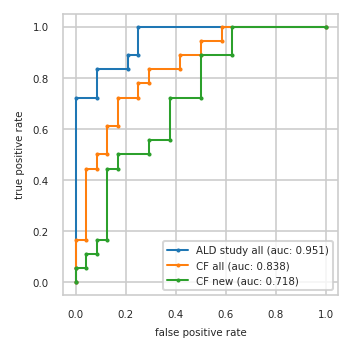

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.722  0.000 0.167  0.042 0.056
3          0.083 0.722  0.042 0.167  0.042 0.111
4          0.083 0.833  0.042 0.444  0.083 0.111
5          0.208 0.833  0.083 0.444  0.083 0.167
6          0.208 0.889  0.083 0.500  0.125 0.167
7          0.250 0.889  0.125 0.500  0.125 0.444
8          0.250 1.000  0.125 0.611  0.167 0.444
9          1.000 1.000  0.167 0.611  0.167 0.500
10           NaN   NaN  0.167 0.722  0.292 0.500
11           NaN   NaN  0.250 0.722  0.292 0.556
12           NaN   NaN  0.250 0.778  0.375 0.556
13           NaN   NaN  0.292 0.778  0.375 0.722
14           NaN   NaN  0.292 0.833  0.500 0.722
15           NaN   NaN  0.417 0.833  0.500 0.889
16           NaN   NaN  0.417 0.889  0.625 0.889
17           NaN   NaN  0.500 0.889  0.625 1.000
18           NaN   NaN  0.500 0.944  1.000 1.000
19           NaN   NaN  0.583 0.944    NaN   NaN
20           NaN   NaN  0.583 1.000    NaN   NaN
21           NaN   NaN  1.000 1.000    NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q92542;Q92542-2,P02766,A0A087WXB8;Q9Y274
2,O95428;O95428-5;O95428-6,F8WAD8;Q9P0K1;Q9P0K1-2;Q9P0K1-3;Q9P0K1-4;Q9P0K1-5,P42262;P42262-2;P42262-3
3,P61981,P08670,P31321
4,C9JF17;P05090,P61981,P51688
5,P04075,Q9Y2T3;Q9Y2T3-3,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
6,P14174,P25189;P25189-2,J3KSJ8;Q9UD71;Q9UD71-2
7,P00338;P00338-3,P04075,Q96GD0
8,Q6EMK4,Q14894,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


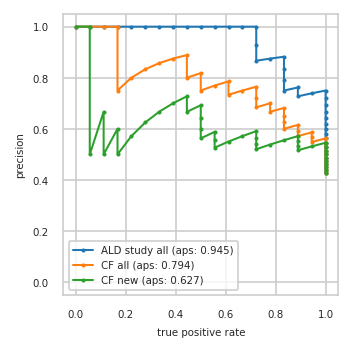

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.545 1.000
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.548 0.944     0.516 0.889
12         0.600 1.000     0.567 0.944     0.533 0.889
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.643 1.000     0.571 0.889     0.571 0.889
15         0.667 1.000     0.593 0.889     0.556 0.833
16         0.692 1.000     0.615 0.889     0.538 0.778
17         0.720 1.000     0.600 0.833     0.520 0.722
18         0.750 1.000     0.625 0.833     0.542 0.722
19         0.739 0.944     0.652 0.833     0.565 0.722
20         0.727 0.889     0.682 0.833     0.591 0.722
21         0.762 0.889     0.667 0.778     0.571 0.667
22         0.750 0.833     0.700 0.778     0.550 0.611
23         0.789 0.833     0.684 0.722     0.526 0.556
24         0.833 0.833     0.722 0.722     0.556 0.556
25         0.882 0.833     0.765 0.722     0.588 0.556
26         0.875 0.778     0.750 0.667     0.562 0.500
27         0.867 0.722     0.733 0.611     0.600 0.500
28         0.929 0.722     0.786 0.611     0.643 0.500
29         1.000 0.722     0.769 0.556     0.692 0.500
30         1.000 0.667     0.750 0.500     0.667 0.444
31         1.000 0.611     0.818 0.500     0.727 0.444
32         1.000 0.556     0.800 0.444     0.700 0.389
33         1.000 0.500     0.889 0.444     0.667 0.333
34         1.000 0.444     0.875 0.389     0.625 0.278
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


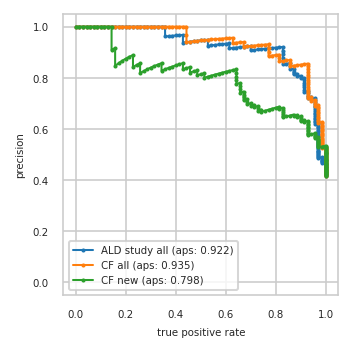

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


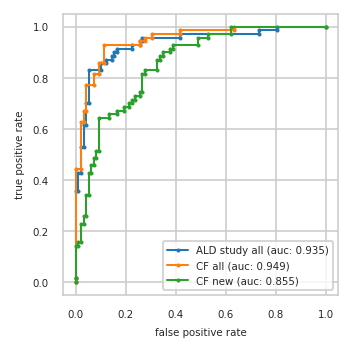

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}